In [7]:
#  lsFit.py
#  G. Cowan / RHUL Physics / July 2025
#  Simple program to illustrate least-squares fitting with iminuit

import numpy as np
import scipy.stats as stats
from scipy.stats import chi2
import iminuit
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import container
plt.rcParams["font.size"] = 14
print("iminuit version:", iminuit.__version__)  # need 2.x

iminuit version: 2.31.1


In [8]:
# set data values (here global)
x   = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])
y   = np.array([2.7, 3.9, 5.5, 5.8, 6.5, 6.3, 7.7, 8.5, 8.7])
sig = np.array([0.3, 0.5, 0.7, 0.6, 0.4, 0.3, 0.7, 0.8, 0.5])
   
# define fit function
def func(x, theta):
    return theta[0] + theta[1]*x

In [9]:
# give names and start values to the parameters
theta0 = 1.0
theta1 = 1.0

# function to be minimized
def chi2(theta):                        # KLUDGE:  data enter as global
    z = (y - func(x, theta))/sig 
    return np.sum(z**2)

In [10]:
# Initialize Minuit and set up fit:
parin   = np.array([theta0, theta1])    # initial values
parname = ['theta0', 'theta1']
parstep = np.array([0.1, 0.1])          # initial setp sizes
parfix  = [False, False]                # change these to fix/free parameters
parlim  = [(None, None), (None, None)]  # set limits if needed
m = Minuit(chi2, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 1.0    

In [11]:
# Do the fit, get errors, extract results
m.migrad()                                        # minimize chi2
thetaHat = m.values                               # LS estimates
sigmaThetaHat = m.errors                          # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

In [12]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(thetaHat[i]), " +/- ",
              "{:.6f}".format(sigmaThetaHat[i]))

print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not(m.fixed[i]):
        for j in range(m.npar):
            if not(m.fixed[j]):
                print(i, j, "{:.6f}".format(cov[i,j]),
                      "{:.6f}".format(rho[i,j]))

par index, name, estimate, standard deviation:
   0 theta0      =  2.257698  +/-  0.292189
   1 theta1      =  0.740933  +/-  0.057231

free par indices, covariance, correlation coeff.:
0 0 0.085374 1.000000
0 1 -0.014376 -0.859706
1 0 -0.014376 -0.859706
1 1 0.003275 1.000000


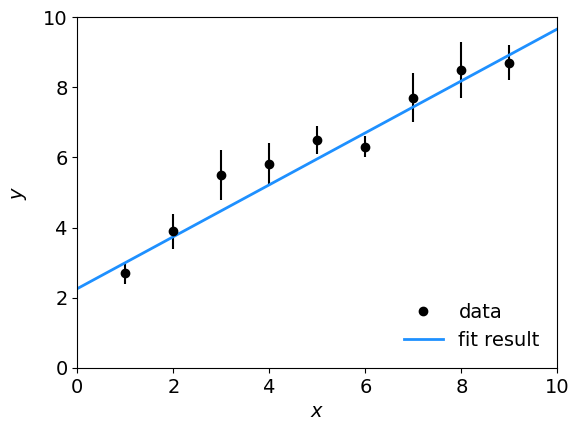

<Figure size 640x480 with 0 Axes>

In [13]:
# Set up plot
fig, ax = plt.subplots(1,1)
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.errorbar(x, y, yerr=sig, xerr=0, color='black', fmt='o', label='data')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$', labelpad=10)
xMin = 0
xMax = 10
yMin = 0
yMax = 10
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
xPlot = np.linspace(xMin, xMax, 100)        # enough points for a smooth curve
fit = func(xPlot, thetaHat)
plt.plot(xPlot, fit, 'dodgerblue', linewidth=2, label='fit result')

# Tweak legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
handles = [handles[0][0], handles[1]]      # turn off error bar in legend
plt.legend(handles, labels, loc='lower right', fontsize=14, frameon=False)

# Make and store plot
plt.show()
plt.savefig("lsFit.pdf", format='pdf')

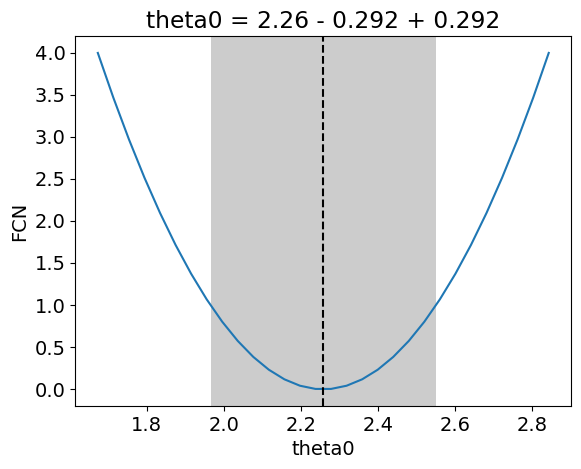

In [14]:
# Make scan of chi2 (for theta0, if free)
if not(m.fixed['theta0']):
    plt.figure()
    m.draw_mnprofile('theta0')
    plt.show()

CL =  0.3934693402873665


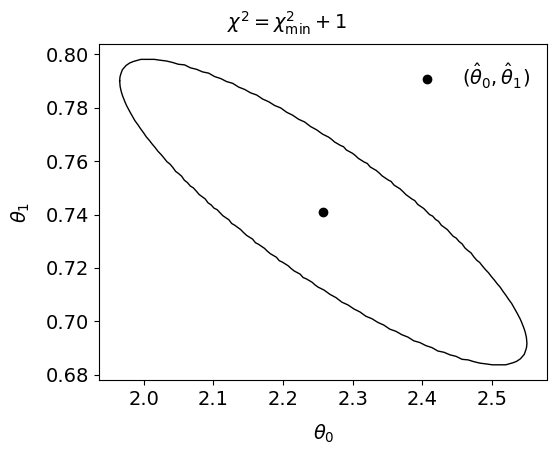

In [15]:
# Make a contour plot of chi2 = chi2_min + 1 (here for theta0 and theta1).
# The tangents to this contour give the standard deviations.
CL = stats.chi2.cdf(1.,2)            #  Q_alpha = 1, npar = 2
print('CL = ', CL)
if not(m.fixed['theta0'] | m.fixed['theta1']):
    fig, ax = plt.subplots(1,1)
    con = m.mncontour('theta0', 'theta1', cl=CL, size=200)
    con = np.vstack([con, con[0]])         # close contour
    plt.plot(thetaHat[0], thetaHat[1], marker='o', linestyle='None',
             color='black', label=r'$(\hat{\theta}_0, \hat{\theta}_1)$')
    plt.plot(con[:,0], con[:,1], color='black', linewidth=1)
    plt.xlabel(r'$\theta_0$', labelpad=10)
    plt.ylabel(r'$\theta_1$', labelpad=10)
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.4, 0.93, r'$\chi^2 = \chi^2_{\rm min} + 1$')
    plt.show()

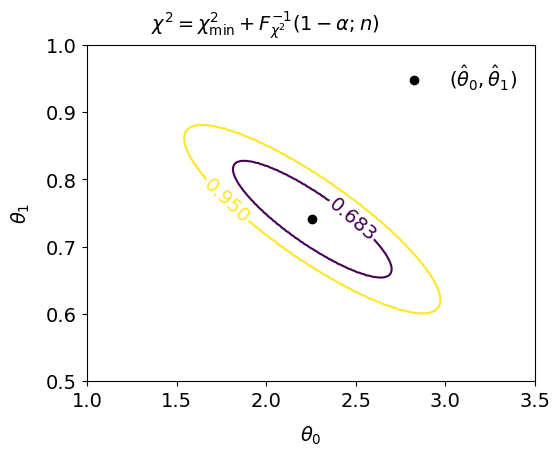

In [16]:
# Confidence region from chi2 = chi2_min + Q (here for theta0 and theta1)
# where Q is the chi2 quantile of CL = 1-alpha = 0.683 and 0.95 for 2 dof.
if not(m.fixed['theta0'] | m.fixed['theta1']):
    fig, ax = plt.subplots(1,1)
    xMin = 1.0
    xMax = 3.5
    yMin = 0.5
    yMax = 1.0
    plt.xlim(xMin, xMax)
    plt.ylim(yMin, yMax)
    m.draw_mncontour('theta0', 'theta1', cl=[0.683, 0.95], size=200);
    plt.plot(thetaHat[0], thetaHat[1], marker='o', linestyle='None',
             color='black', label=r'$(\hat{\theta}_0, \hat{\theta}_1)$')
    plt.xlabel(r'$\theta_0$', labelpad=10)
    plt.ylabel(r'$\theta_1$', labelpad=10)
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.3, 0.93,
                r'$\chi^2 = \chi^2_{\rm min} + F^{-1}_{\chi^2}(1-\alpha;n)$')
    plt.show()